In [190]:
import numpy as np
import pandas as pd
import pandas_profiling as pp

import matplotlib.pyplot as plt
from fetch_data import load_data, prepare_data
from scipy.stats import kurtosis, normaltest, norm, describe, zscore

from statsmodels.stats.diagnostic import kstest_normal, normal_ad, kstest_fit
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.api as sm

from preprocess import Gaussianize

In [58]:
path = '../data/BTCUSD'
data = load_data(path, new_data=False)
data = data[data.index <= '2021-05-01']

## Volatility Clustering and Ubnormal Volatility

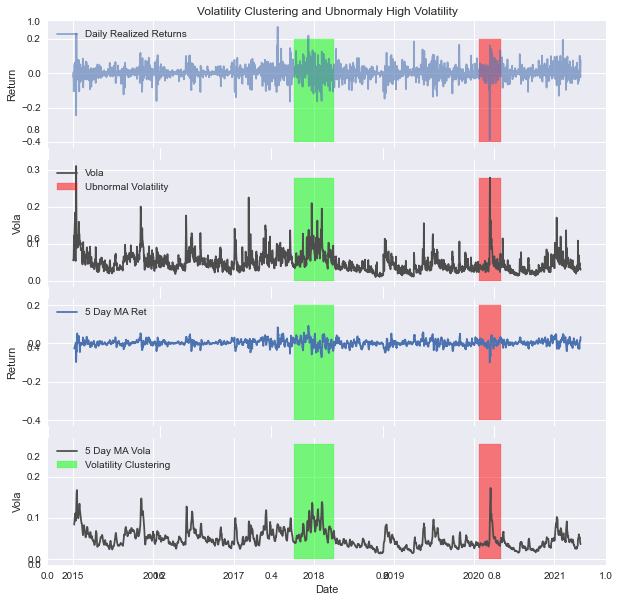

In [59]:
dataset = prepare_data(data, freq='D')
plt.style.use('seaborn')

fig = plt.figure(figsize=(10, 10))
plt.title('Volatility Clustering and Ubnormaly High Volatility')

#################3
ret_ax = fig.add_subplot(4, 1, 1)
ret_ax.plot(dataset['ret'], alpha=0.6, label='Daily Realized Returns')
ret_ax.set_ylabel('Return')
ret_ax.tick_params(labelbottom=False)

#######################

vola_ax = fig.add_subplot(4, 1, 4, sharex=ret_ax)
vola_ax.plot(dataset['Volatility'].rolling(5).mean(), color=(0.3, 0.3, 0.3), label='5 Day MA Vola')
#ax1.tick_params(labelbottom=False)
vola_ax.set_ylabel('Vola')
vola_ax.set_xlabel('Date')


######################

retma_ax = fig.add_subplot(4, 1, 3, sharex=ret_ax)
retma_ax.plot(dataset['ret'].rolling(5).mean(), label='5 Day MA Ret')
retma_ax.legend(loc='best')
retma_ax.tick_params(labelbottom=False)
retma_ax.set_ylabel('Return')



############################

volama_ax = fig.add_subplot(4, 1, 2, sharex=ret_ax)
volama_ax.plot(dataset['Volatility'], color=(0.3, 0.3, 0.3), label='Vola')
volama_ax.legend(loc='best')
volama_ax.tick_params(labelbottom=False)
volama_ax.set_ylabel('Vola')


##############################

plt.subplots_adjust(wspace=0.1, hspace=0.1)



####################### Abnormal Volatility
max_vola_date = dataset[dataset.index >= '2019-01-01']['Volatility'].argmax()
max_vola = dataset[dataset.index >= '2019-01-01']['Volatility'].max()

fill_ret = np.linspace(-0.4, 0.2, 100)
fill_vola = np.linspace(0, max_vola, 100)

x1 = [dataset[dataset.index >= '2019-01-01'].index[max_vola_date - 50]]*100
x2 = [dataset[dataset.index >= '2019-01-01'].index[max_vola_date + 50]]*100

volama_ax.fill_betweenx(fill_vola, x1, x2, alpha=0.5, color=(1, 0, 0), label='Ubnormal Volatility')
vola_ax.fill_betweenx(fill_vola, x1, x2, alpha=0.5, color=(1, 0, 0))
ret_ax.fill_betweenx(fill_ret, x1, x2, alpha=0.5, color=(1, 0, 0))
retma_ax.fill_betweenx(fill_ret, x1, x2, alpha=0.5, color=(1, 0, 0))

####################### Volatility Clustering

mask = (dataset.index >= '2018-08-01') & (dataset.index <= '2018-02-01')
date1 = ['2017-10-01']*100
date2 = ['2018-04-01']*100

fill_vola = np.linspace(0, max_vola, 100)
fill_ret = np.linspace(-0.4, 0.2, 100)

vola_ax.fill_betweenx(fill_vola, date1, date2, alpha=0.5, color=(0, 1, 0), label='Volatility Clustering')
volama_ax.fill_betweenx(fill_vola, date1, date2, alpha=0.5, color=(0, 1, 0))
ret_ax.fill_betweenx(fill_ret, date1, date2, alpha=0.5, color=(0, 1, 0))
retma_ax.fill_betweenx(fill_ret, date1, date2, alpha=0.5, color=(0, 1, 0))



############################
ret_ax.legend(loc='upper left')
vola_ax.legend(loc='upper left')
retma_ax.legend(loc='upper left')
volama_ax.legend(loc='upper left')
####################3
plt.savefig('vola_clustering.pdf')



## Leverage and Volume Effect

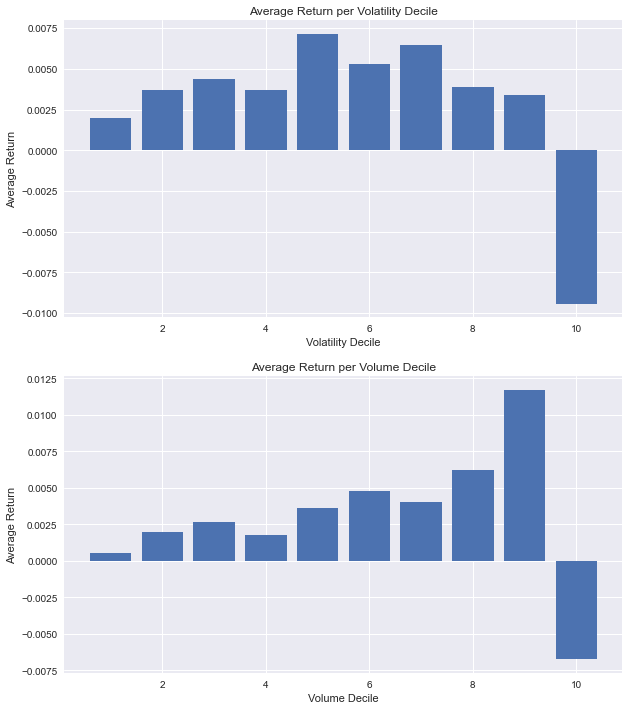

In [177]:
fig = plt.figure(figsize=(10, 12))
# dataset['decile'] = 1 + dataset[['ret']].transform(lambda x: pd.qcut(x, 10, labels=False))
# decile_ret = dataset[['ret', 'decile']].groupby('decile').mean()


#ax1 = fig.add_subplot(2, 1, 1)

#ax1.set_title('Average Return per Return Decile')
# ax1.bar([x for x in range(1, 11)], decile_ret['ret'])
# ax1.set_ylabel('Average Return')

dataset['decile'] = 1 + dataset[['Volatility']].transform(lambda x: pd.qcut(x, 10, labels=False))
decile_ret = dataset[['ret', 'decile']].groupby('decile').mean()

ax2 = fig.add_subplot(2, 1, 1)

ax2.bar([x for x in range(1, 11)], decile_ret['ret'])
ax2.set_title('Average Return per Volatility Decile')
ax2.set_xlabel('Volatility Decile')
ax2.set_ylabel('Average Return')

dataset['decile'] = 1 + dataset[['Volume']].transform(lambda x: pd.qcut(x, 10, labels=False))
decile_ret = dataset[['ret', 'decile']].groupby('decile').mean()


ax3 = fig.add_subplot(2, 1, 2)
ax3.bar([x for x in range(1, 11)], decile_ret['ret'])
ax3.set_title('Average Return per Volume Decile')
ax3.set_xlabel('Volume Decile')
ax3.set_ylabel('Average Return')


plt.savefig('leverage_effect.pdf')

## Descriptive Statistics

In [171]:
print('BTC')
ret_stat = dataset['ret'].describe()
ret_stat.loc['var'] = dataset['ret'].var().tolist()
ret_stat.loc['Skew'] = dataset['ret'].skew().tolist()
ret_stat.loc['Kurt'] = dataset['ret'].kurtosis().tolist() + 3 #fisher correction
print(ret_stat)

BTC
count    2309.000000
mean        0.003051
std         0.039793
min        -0.389801
25%        -0.012139
50%         0.002003
75%         0.018700
max         0.269211
var         0.001583
Skew       -0.182073
Kurt       11.523937
Name: ret, dtype: float64


C:\Users\Luka\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


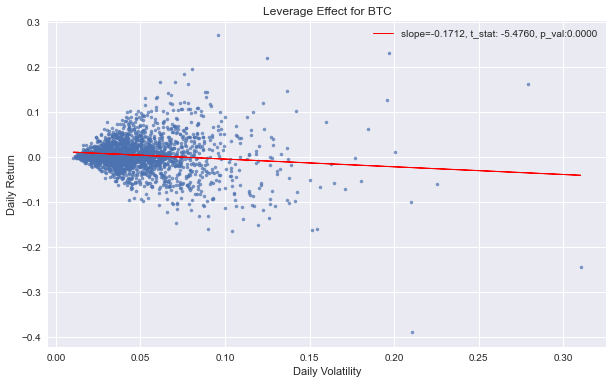

In [147]:
mod = sm.OLS(dataset['ret'], sm.add_constant(dataset[['Volatility']]))
res = mod.fit()
#print(res.summary())
alpha, beta = res.params
pval = res.pvalues[1]
t_stat = res.tvalues[1]


plt.figure(figsize=(10, 6))
plt.title('Leverage Effect for BTC')
plt.scatter(dataset['Volatility'], dataset['ret'], s=10, alpha=0.7)
plt.plot(dataset['Volatility'], alpha + dataset['Volatility'] * beta, color='r', linewidth=1, label=f'slope={beta:.4f}, t_stat: {t_stat:.4f}, p_val:{pval:.4f}', )
plt.xlabel('Daily Volatility')
plt.ylabel('Daily Return')
plt.legend()
plt.savefig('leverage_ols.pdf')

## Statistical Tests for Normality of Returns and Unit Root 

Augmented Dickey–Fuller Test for Stationarity of Returns
(-50.46826349732333, 0.0, {'1%': -3.4331864765491247, '5%': -2.862793094456392, '10%': -2.5674370784536644}, <statsmodels.stats.diagnostic.ResultsStore object at 0x0000024C9C2AD5B0>)
loc: 0.003051, scale: 0.039784
kurtosis: 11.502892
D’Agostino and Pearson’s Normality Test
NormaltestResult(statistic=388.35304923659237, pvalue=4.6795796438141205e-85)
Kolmogorov-Smirnov Normality Test
(0.1041366877491425, 0.0009999999999998899)
Anderson-Darling test 
(55.19809351193999, 0.0)


C:\Users\Luka\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


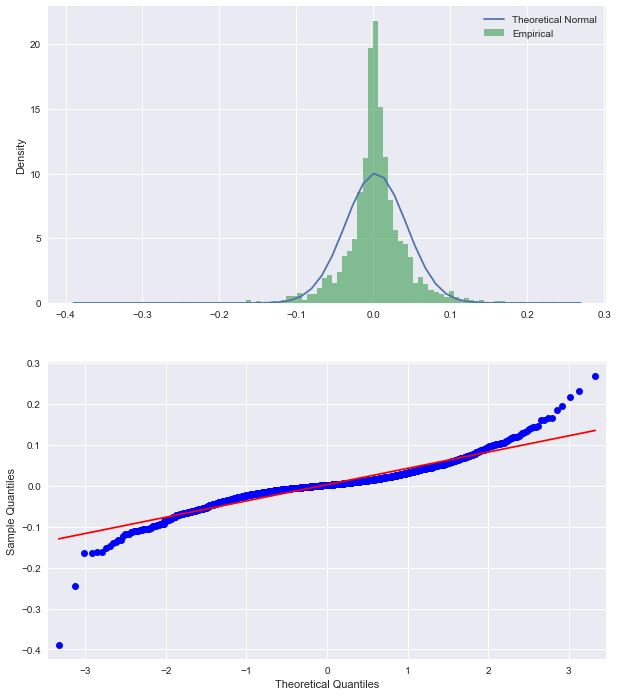

In [189]:
print("Augmented Dickey–Fuller Test for Stationarity of Returns")
print(adfuller(dataset['ret'], regresults=True))

loc, scale = norm.fit(dataset['ret'])
print(f'loc: {loc:.6f}, scale: {scale:.6f}')
print(f'kurtosis: {kurtosis(dataset["ret"], fisher=False):.6f}')

print("D’Agostino and Pearson’s Normality Test")
print(normaltest(dataset['ret']))

print("Kolmogorov-Smirnov Normality Test")
print(kstest_normal(dataset['ret']))

print("Anderson-Darling test ")
print(normal_ad(dataset['ret']))


xmin, xmax = dataset['ret'].min(), dataset['ret'].max()
x = np.linspace(xmin, xmax)

fig = plt.figure(figsize=(10, 12))

ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(x, norm.pdf(x, loc, scale), label='Theoretical Normal')
ax1.hist(dataset['ret'], alpha=0.7, bins=100, density=True, label='Empirical')
ax1.set_ylabel('Density')
plt.legend()

ax2 = fig.add_subplot(2, 1, 2)
sm.qqplot(dataset['ret'], line='s', ax=ax2)


plt.savefig('heavy_tails.pdf')

C:\Users\Luka\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


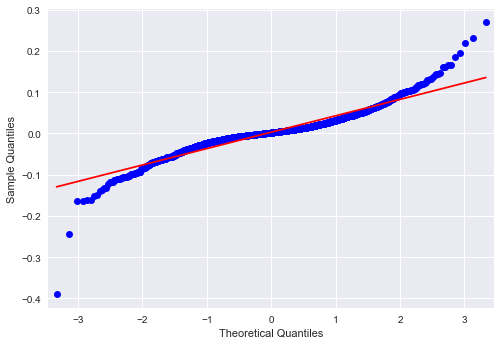

## Correlation of returns

ACF & PACF


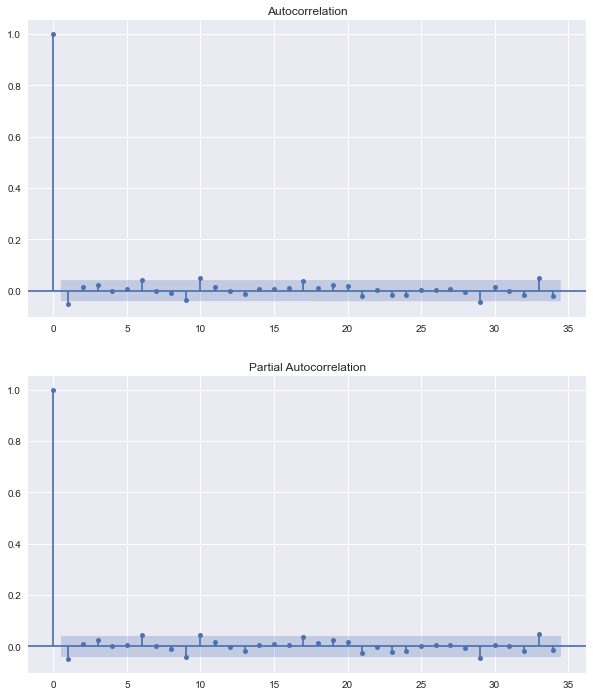

In [182]:
print('ACF & PACF')
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(2, 1, 1)
plot_acf(dataset['ret'], ax=ax1)
ax2 = fig.add_subplot(2, 1, 2)
plot_pacf(dataset['ret'], ax=ax2)

plt.savefig('acf_pcf.pdf')




In [229]:
logret = np.log(data['Close']).diff().resample('D').sum()
logret = logret[logret.index <= '2021-05-01'].dropna().to_numpy()


gaus = Gaussianize()
gaus.fit(logret)
u = gaus.transform(logret)


h:\My Drive\EPFL Account\ml4f\ml4f_project\src\preprocess.py:25: RuntimeWarning: invalid value encountered in true_divide
  return np.sign(z) * np.sqrt(np.real(lambertw(delta * z ** 2)) / delta)


6.727811359562386e-05 1000


C:\Users\Luka\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


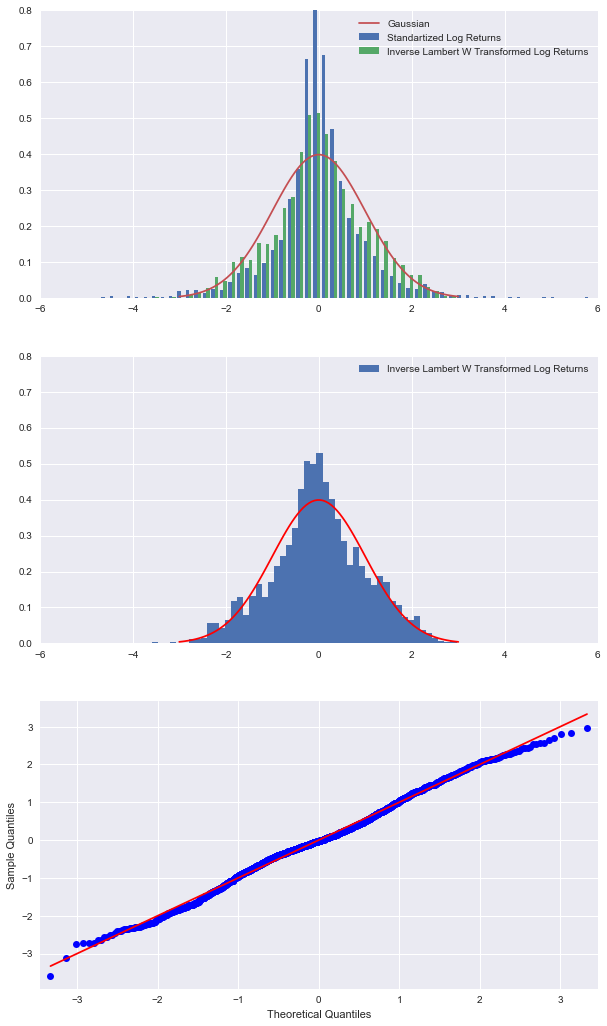

In [233]:

x = np.linspace(-3, 3, 100)

fig  = plt.figure(figsize=(10, 18))
ax1 = fig.add_subplot(3, 1, 1)

ax1.hist([zscore(logret), u], bins=100, label=['Standartized Log Returns', 'Inverse Lambert W Transformed Log Returns'], density=True)
ax1.plot(x, norm.pdf(x), label='Gaussian')
ax1.set_xlim(-6, 6)
ax1.set_ylim(0, 0.8)
ax1.legend()


ax2 = fig.add_subplot(3, 1, 2)
ax2.hist(u, bins=50, label='Inverse Lambert W Transformed Log Returns', density=True)
ax2.plot(x, norm.pdf(x), color='r')
ax2.set_xlim(-6, 6)
ax2.set_ylim(0, 0.8)
ax2.legend()

ax3 = fig.add_subplot(3, 1, 3)

qqplot(u, ax=ax3, line='s')

plt.savefig('lambert.pdf')

In [226]:
print('BTC')
pd.set_option('display.float_format', lambda x: '%.5f' % x)
u = pd.DataFrame(u)
ret_stat = u.describe()
ret_stat.loc['var'] = u.var().tolist()
ret_stat.loc['Skew'] = u.skew().tolist()
ret_stat.loc['Kurt'] = u.kurtosis() + 3 #fisher correction
display(ret_stat)

BTC


,0
count,2313.00000
mean,-0.00000
std,1.00023
min,-3.58602
25%,-0.58349
50%,-0.02394
75%,0.62524
max,2.96289
var,1.00047
Skew,-0.04149


In [234]:
loc, scale = norm.fit(u)
print(f'loc: {loc:.6f}, scale: {scale:.6f}')
print(f'kurtosis: {kurtosis(u, fisher=False):.6f}')

print("D’Agostino and Pearson’s Normality Test")
print(normaltest(u))

print("Kolmogorov-Smirnov Normality Test")
print(kstest_normal(u))

print("Anderson-Darling test ")
print(normal_ad(u))


loc: -0.000000, scale: 1.000017
kurtosis: 3.000122
D’Agostino and Pearson’s Normality Test
NormaltestResult(statistic=0.672502244735948, pvalue=0.7144436705005696)
Kolmogorov-Smirnov Normality Test
(0.038322788514717154, 0.0009999999999998899)
Anderson-Darling test 
(4.404145248612622, 6.244596535166921e-11)
